In [ ]:
# Librerias:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import distance_transform_edt

from tqdm import tqdm

# Analisis de los datos

In [ ]:
# Carga del dataset
from google.colab import drive
drive.mount('/content/drive')

train_imgs_path =  "/content/drive/MyDrive/cardiac_data/train_imgs.npy"
train_annot_path = "/content/drive/MyDrive/cardiac_data/train_annot.npy"


val_imgs_path = "/content/drive/MyDrive/cardiac_data/val_imgs.npy"
val_annot_path = "/content/drive/MyDrive/cardiac_data/val_annot.npy"


test_imgs_path = "/content/drive/MyDrive/cardiac_data/test_imgs.npy"
test_annot_path = "/content/drive/MyDrive/cardiac_data/test_annot.npy"

train_imgs = np.load(train_imgs_path)
train_masks = np.load(train_annot_path)

val_imgs = np.load(val_imgs_path)
val_masks = np.load(val_annot_path)

test_imgs = np.load(test_imgs_path)
test_masks = np.load(test_annot_path)

#filtamos las mascaras solo por zona gris o =1
train_masks = np.where(train_masks == 2, 0, train_masks)
val_masks = np.where(val_masks == 2, 0, val_masks)
test_masks = np.where(test_masks == 2, 0, test_masks)

# Vemos que el conjunto de entrenamiento tiene 4564 muestras
print("Train images shape:", train_imgs.shape)
print("Train masks shape:", train_masks.shape)

print("Validation images shape:", val_imgs.shape)
print("Validation masks shape:", val_masks.shape)

print("Test images shape:", test_imgs.shape)
print("Test masks shape:", test_masks.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train images shape: (4564, 256, 256)
Train masks shape: (4564, 256, 256)
Validation images shape: (502, 256, 256)
Validation masks shape: (502, 256, 256)
Test images shape: (1240, 256, 256)
Test masks shape: (1240, 256, 256)


In [ ]:
# Para verificar que reemplazaron correctamente los datos

unique_values_train = np.unique(train_masks)
print("Unique values in the segmentation masks (train):", unique_values_train)
unique_values_val = np.unique(val_masks)
print("Unique values in the segmentation masks (validdation):", unique_values_val)
unique_values_test = np.unique(test_masks)
print("Unique values in the segmentation masks (test):", unique_values_test)

Unique values in the segmentation masks (train): [0 1]
Unique values in the segmentation masks (validdation): [0 1]
Unique values in the segmentation masks (test): [0 1]


In [ ]:

class CardiacDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # numpy arrays a PyTorch tensors
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long() # Use long for cross-entropy target

        # agregar canal a imagen (grayscale, [1, H, W])
        image = image.unsqueeze(0)

        return image, mask

#Guardamos los datos en data set
train_dataset = CardiacDataset(train_imgs, train_masks)
val_dataset = CardiacDataset(val_imgs, val_masks)

# batch size
batch_size = 32

# crear DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")

# Test retrieving a batch
train_images_batch, train_masks_batch = next(iter(train_dataloader))
print("Shape of a training image batch:", train_images_batch.shape)
print("Shape of a training mask batch:", train_masks_batch.shape)

val_images_batch, val_masks_batch = next(iter(val_dataloader))
print("Shape of a validation image batch:", val_images_batch.shape)
print("Shape of a validation mask batch:", val_masks_batch.shape)

Number of training batches: 143
Number of validation batches: 16
Shape of a training image batch: torch.Size([32, 1, 256, 256])
Shape of a training mask batch: torch.Size([32, 256, 256])
Shape of a validation image batch: torch.Size([32, 1, 256, 256])
Shape of a validation mask batch: torch.Size([32, 256, 256])


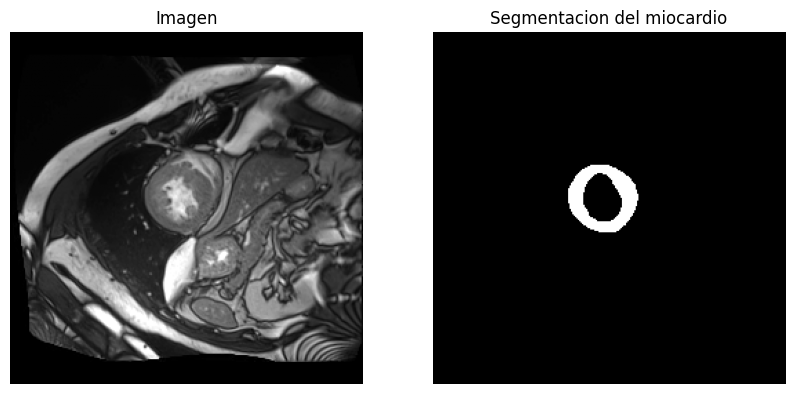

In [ ]:
# Seleccionar un índice para visualizar (por ejemplo la primera imagen)
idx = 40
image = train_imgs[idx] #Almacenamos la matriz de pixeles (escala de grises) en esta variable

mask = train_masks[idx] # Matriz con la salida deseada (segmentacion)
                        #  sus componentes toman el valor 0 (zona negra), 1(zona gris) o 2(zona blanca)

# Mostrar la imagen y la segmentacion
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image, cmap="gray")
plt.title("Imagen")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Segmentacion del miocardio")
plt.axis("off")

plt.show()

In [ ]:
def calculate_pixel_percentage(masks):
    total_pixels = masks.size
    one_pixels = np.sum(masks == 1)
    return (one_pixels / total_pixels) * 100

train_percentage = calculate_pixel_percentage(train_masks)
val_percentage = calculate_pixel_percentage(val_masks)
test_percentage = calculate_pixel_percentage(test_masks)

print(f"Percentage of pixels with value 1 in train masks: {train_percentage:.2f}%")
print(f"Percentage of pixels with value 1 in validation masks: {val_percentage:.2f}%")
print(f"Percentage of pixels with value 1 in test masks: {test_percentage:.2f}%")

Percentage of pixels with value 1 in train masks: 1.14%
Percentage of pixels with value 1 in validation masks: 1.19%
Percentage of pixels with value 1 in test masks: 1.23%


# Arquitectura

In [ ]:
#double 3x3 convolution
def dual_conv(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )

class Unet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(Unet, self).__init__()

        # Encoder
        self.dwn_conv1 = dual_conv(in_channels, 64)
        self.dwn_conv2 = dual_conv(64, 128)
        self.dwn_conv3 = dual_conv(128, 256)
        self.dwn_conv4 = dual_conv(256, 512)
        self.dwn_conv5 = dual_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(2)

        # Decoder
        self.trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = dual_conv(1024, 512)
        self.trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = dual_conv(512, 256)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = dual_conv(256, 128)
        self.trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = dual_conv(128, 64)

        # Output
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.dwn_conv1(x)
        x2 = self.maxpool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.dwn_conv5(x8)

        # Decoder
        x = self.trans1(x9)
        x = self.up_conv1(torch.cat([x, x7], dim=1))
        x = self.trans2(x)
        x = self.up_conv2(torch.cat([x, x5], dim=1))
        x = self.trans3(x)
        x = self.up_conv3(torch.cat([x, x3], dim=1))
        x = self.trans4(x)
        x = self.up_conv4(torch.cat([x, x1], dim=1))

        return self.out(x)


# Funciones de costo

In [ ]:

bce_loss = nn.BCEWithLogitsLoss()


def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))


def combined_loss(pred, target):
    return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)


def dice_score(pred, target, eps=1e-6):
    pred = torch.argmax(pred, dim=1)
    intersection = (pred * target).sum().float()
    return (2. * intersection + eps) / (pred.sum() + target.sum() + eps)


#  IOU
def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)



# Optimizador Adam Normal

## Loss Only Dice

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

num_epochs = 10

Epoch [1/10] Train Loss: 0.7741 | Val Loss: 0.6968 | Train IoU: 0.1430 | Val IoU: 0.1942
Epoch [2/10] Train Loss: 0.3455 | Val Loss: 0.3630 | Train IoU: 0.4921 | Val IoU: 0.4826
Epoch [3/10] Train Loss: 0.2192 | Val Loss: 0.3179 | Train IoU: 0.6437 | Val IoU: 0.5328
Epoch [4/10] Train Loss: 0.1705 | Val Loss: 0.2448 | Train IoU: 0.7107 | Val IoU: 0.6126
Epoch [5/10] Train Loss: 0.1394 | Val Loss: 0.2561 | Train IoU: 0.7567 | Val IoU: 0.5998
Epoch [6/10] Train Loss: 0.1243 | Val Loss: 0.2658 | Train IoU: 0.7799 | Val IoU: 0.5913
Epoch [7/10] Train Loss: 0.1138 | Val Loss: 0.2244 | Train IoU: 0.7965 | Val IoU: 0.6394
Epoch [8/10] Train Loss: 0.1079 | Val Loss: 0.2499 | Train IoU: 0.8060 | Val IoU: 0.6146
Epoch [9/10] Train Loss: 0.1021 | Val Loss: 0.2191 | Train IoU: 0.8155 | Val IoU: 0.6485
Epoch [10/10] Train Loss: 0.0984 | Val Loss: 0.2142 | Train IoU: 0.8215 | Val IoU: 0.6523


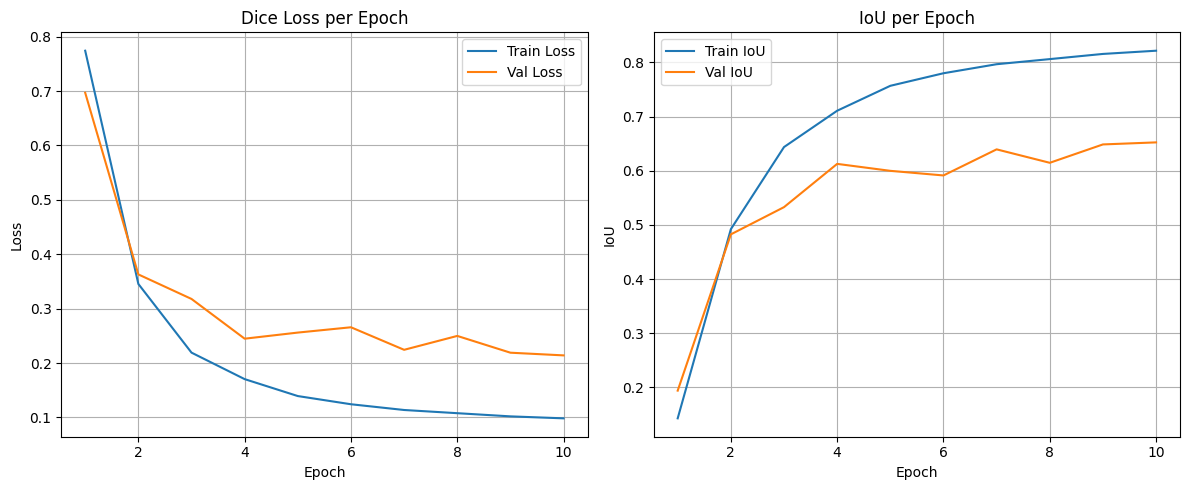

In [ ]:
train_losses, val_losses = [], []
train_ious, val_ious = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, running_iou = 0.0, 0.0

    for imgs, masks in train_dataloader:
        imgs, masks = imgs.to(device), masks.to(device)

        # asegursrse shape [B,1,H,W]
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)

        # cambia masks a Float para BCEWithLogitsLoss
        masks = masks.float()

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_iou += iou_score(outputs, masks).item()

    train_losses.append(running_loss / len(train_dataloader))
    train_ious.append(running_iou / len(train_dataloader))


    model.eval()
    val_loss, val_iou = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)

            # cambia masks a Float para BCEWithLogitsLoss
            masks = masks.float()

            outputs = model(imgs)
            val_loss += dice_loss(outputs, masks).item()
            val_iou += iou_score(outputs, masks).item()

    val_losses.append(val_loss / len(val_dataloader))
    val_ious.append(val_iou / len(val_dataloader))

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} "
          f"| Train IoU: {train_ious[-1]:.4f} | Val IoU: {val_ious[-1]:.4f}")

epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dice Loss per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_ious, label='Train IoU')
plt.plot(epochs, val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Number of test batches: 39
Test Loss: 0.1934 | Test IoU: 0.6810


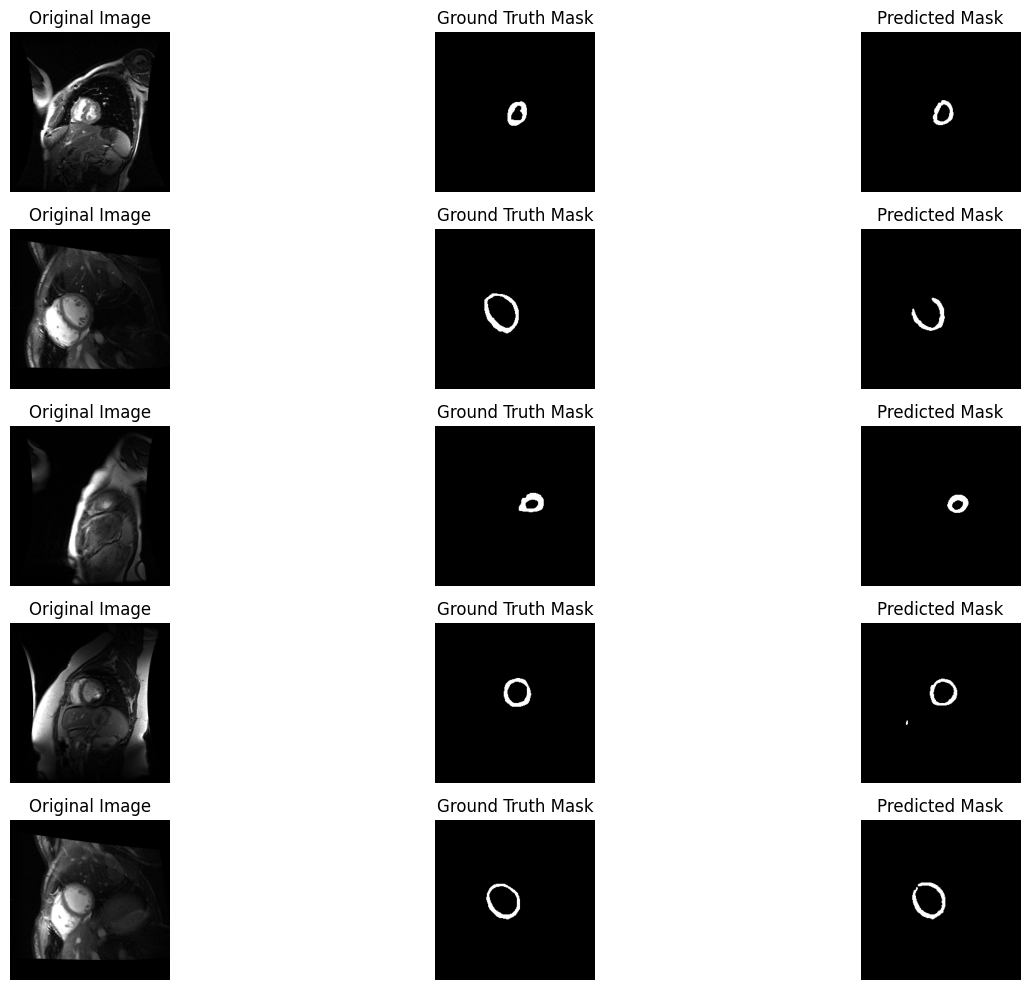

In [ ]:
# Modelo a modo evaluacion
model.eval()

test_dataset = CardiacDataset(test_imgs, test_masks)

# creamos DataLoader para test set
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of test batches: {len(test_dataloader)}")

test_loss, test_iou = 0.0, 0.0
with torch.no_grad():
    for imgs, masks in test_dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)

        # Cast masks to Float for BCEWithLogitsLoss
        masks = masks.float()

        outputs = model(imgs)
        test_loss += dice_loss(outputs, masks).item()
        test_iou += iou_score(outputs, masks).item()

print(f"Test Loss: {test_loss / len(test_dataloader):.4f} | Test IoU: {test_iou / len(test_dataloader):.4f}")

# vizualicemos algunos ejemplos
def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        image = image.to(device).unsqueeze(0) # Add batch dimension

        with torch.no_grad():
            output = model(image)
            predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()
            predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

        image = image.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()


        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataset, device)

## Loss combinado

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

num_epochs = 10

Epoch [1/10] Train Loss: 0.4881 | Val Loss: 0.3835 | Train IoU: 0.0926 | Val IoU: 0.2147
Epoch [2/10] Train Loss: 0.2455 | Val Loss: 0.2782 | Train IoU: 0.4157 | Val IoU: 0.3535
Epoch [3/10] Train Loss: 0.1662 | Val Loss: 0.2191 | Train IoU: 0.5593 | Val IoU: 0.4602
Epoch [4/10] Train Loss: 0.1238 | Val Loss: 0.1778 | Train IoU: 0.6504 | Val IoU: 0.5379
Epoch [5/10] Train Loss: 0.1016 | Val Loss: 0.1631 | Train IoU: 0.7029 | Val IoU: 0.5652
Epoch [6/10] Train Loss: 0.0878 | Val Loss: 0.1769 | Train IoU: 0.7374 | Val IoU: 0.5463
Epoch [7/10] Train Loss: 0.0775 | Val Loss: 0.1726 | Train IoU: 0.7643 | Val IoU: 0.5567
Epoch [8/10] Train Loss: 0.0722 | Val Loss: 0.1528 | Train IoU: 0.7784 | Val IoU: 0.5903
Epoch [9/10] Train Loss: 0.0666 | Val Loss: 0.1577 | Train IoU: 0.7938 | Val IoU: 0.5854
Epoch [10/10] Train Loss: 0.0633 | Val Loss: 0.1481 | Train IoU: 0.8027 | Val IoU: 0.6041


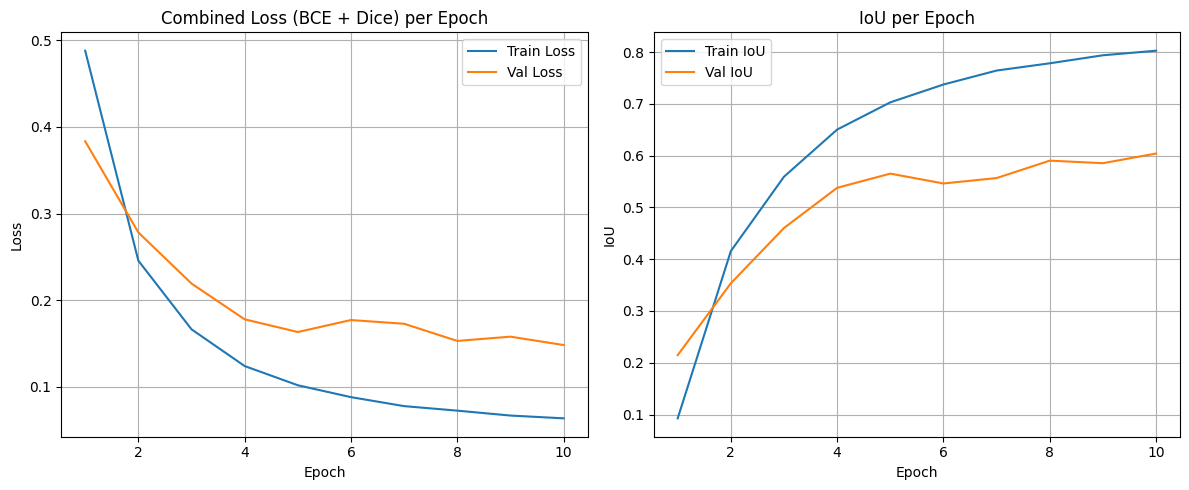

In [ ]:
train_losses, val_losses = [], []
train_ious, val_ious = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, running_iou = 0.0, 0.0

    for imgs, masks in train_dataloader:
        imgs, masks = imgs.to(device), masks.to(device)

        # asegursrse shape [B,1,H,W]
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)

        # cambia masks a Float para BCEWithLogitsLoss
        masks = masks.float()

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_iou += iou_score(outputs, masks).item()

    train_losses.append(running_loss / len(train_dataloader))
    train_ious.append(running_iou / len(train_dataloader))


    model.eval()
    val_loss, val_iou = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)

            # cambia masks a Float para BCEWithLogitsLoss
            masks = masks.float()

            outputs = model(imgs)
            val_loss += combined_loss(outputs, masks).item()
            val_iou += iou_score(outputs, masks).item()

    val_losses.append(val_loss / len(val_dataloader))
    val_ious.append(val_iou / len(val_dataloader))

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} "
          f"| Train IoU: {train_ious[-1]:.4f} | Val IoU: {val_ious[-1]:.4f}")

epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Combined Loss (BCE + Dice) per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_ious, label='Train IoU')
plt.plot(epochs, val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Number of test batches: 39
Test Loss: 0.1419 | Test IoU: 0.6296


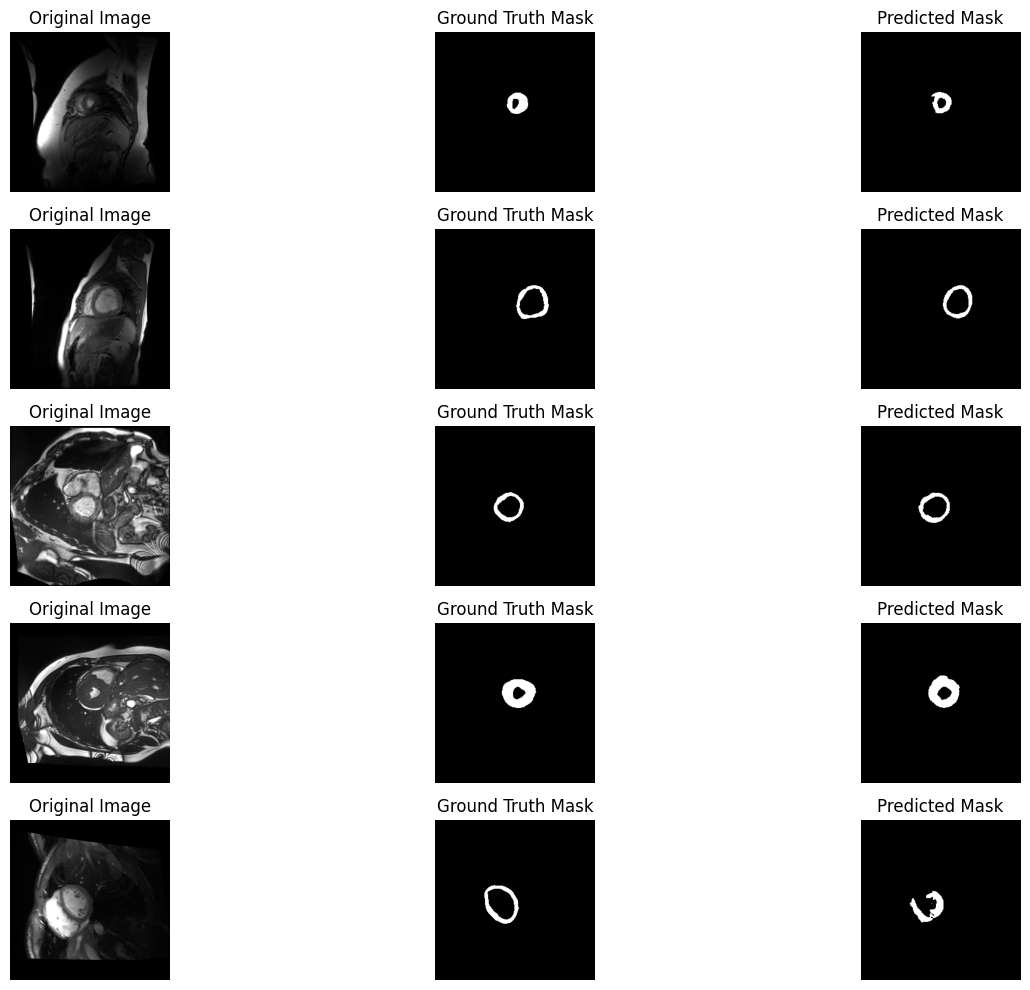

In [ ]:
# Modelo a modo evaluacion
model.eval()

test_dataset = CardiacDataset(test_imgs, test_masks)

# creamos DataLoader para test set
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of test batches: {len(test_dataloader)}")

test_loss, test_iou = 0.0, 0.0
with torch.no_grad():
    for imgs, masks in test_dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)

        # Cast masks to Float for BCEWithLogitsLoss
        masks = masks.float()

        outputs = model(imgs)
        test_loss += combined_loss(outputs, masks).item()
        test_iou += iou_score(outputs, masks).item()

print(f"Test Loss: {test_loss / len(test_dataloader):.4f} | Test IoU: {test_iou / len(test_dataloader):.4f}")

# vizualicemos algunos ejemplos
def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        image = image.to(device).unsqueeze(0) # Add batch dimension

        with torch.no_grad():
            output = model(image)
            predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()
            predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

        image = image.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()


        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataset, device)

# Optimizador Adam W

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(in_channels=1, out_channels=2).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

num_epochs = 10

Epoch [1/10] Train Loss: 0.7214 | Val Loss: 0.5442 | Train IoU: 0.1809 | Val IoU: 0.3229
Epoch [2/10] Train Loss: 0.3071 | Val Loss: 0.3472 | Train IoU: 0.5362 | Val IoU: 0.4964
Epoch [3/10] Train Loss: 0.1933 | Val Loss: 0.2558 | Train IoU: 0.6783 | Val IoU: 0.6012
Epoch [4/10] Train Loss: 0.1527 | Val Loss: 0.2539 | Train IoU: 0.7367 | Val IoU: 0.6037
Epoch [5/10] Train Loss: 0.1303 | Val Loss: 0.2388 | Train IoU: 0.7706 | Val IoU: 0.6227
Epoch [6/10] Train Loss: 0.1158 | Val Loss: 0.2521 | Train IoU: 0.7933 | Val IoU: 0.6062
Epoch [7/10] Train Loss: 0.1079 | Val Loss: 0.2439 | Train IoU: 0.8061 | Val IoU: 0.6202
Epoch [8/10] Train Loss: 0.1029 | Val Loss: 0.2690 | Train IoU: 0.8140 | Val IoU: 0.5939
Epoch [9/10] Train Loss: 0.0970 | Val Loss: 0.2301 | Train IoU: 0.8237 | Val IoU: 0.6382
Epoch [10/10] Train Loss: 0.0941 | Val Loss: 0.2203 | Train IoU: 0.8285 | Val IoU: 0.6480


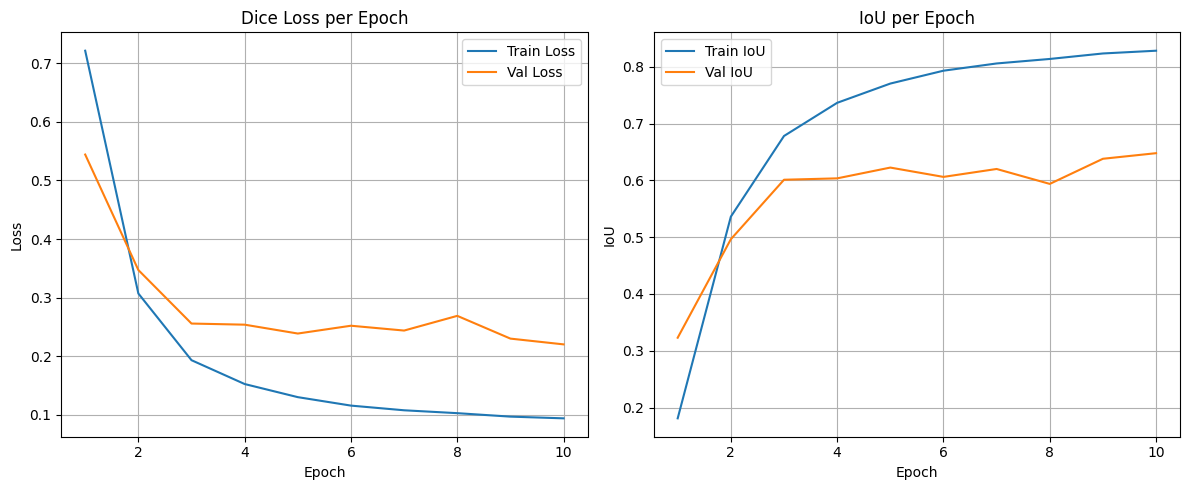

In [ ]:
train_losses, val_losses = [], []
train_ious, val_ious = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, running_iou = 0.0, 0.0

    for imgs, masks in train_dataloader:
        imgs, masks = imgs.to(device), masks.to(device)

        # asegursrse shape [B,1,H,W]
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)

        # cambia masks a Float para BCEWithLogitsLoss
        masks = masks.float()

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_iou += iou_score(outputs, masks).item()

    train_losses.append(running_loss / len(train_dataloader))
    train_ious.append(running_iou / len(train_dataloader))


    model.eval()
    val_loss, val_iou = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)

            # cambia masks a Float para BCEWithLogitsLoss
            masks = masks.float()

            outputs = model(imgs)
            val_loss += dice_loss(outputs, masks).item()
            val_iou += iou_score(outputs, masks).item()

    val_losses.append(val_loss / len(val_dataloader))
    val_ious.append(val_iou / len(val_dataloader))

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} "
          f"| Train IoU: {train_ious[-1]:.4f} | Val IoU: {val_ious[-1]:.4f}")

epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dice Loss per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_ious, label='Train IoU')
plt.plot(epochs, val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Number of test batches: 39
Test Loss: 0.1919 | Test IoU: 0.6896


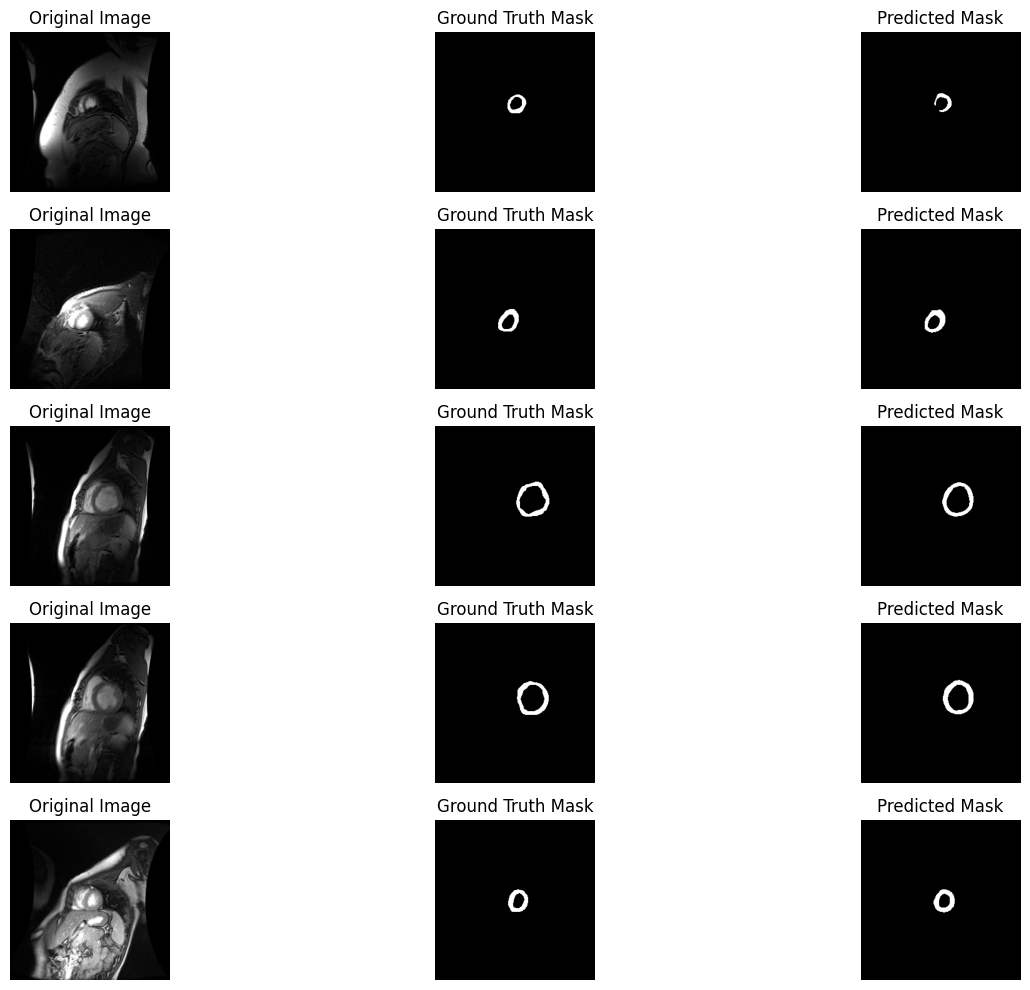

In [ ]:
# Modelo a modo evaluacion
model.eval()

test_dataset = CardiacDataset(test_imgs, test_masks)

# creamos DataLoader para test set
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of test batches: {len(test_dataloader)}")

test_loss, test_iou = 0.0, 0.0
with torch.no_grad():
    for imgs, masks in test_dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)

        # Cast masks to Float for BCEWithLogitsLoss
        masks = masks.float()

        outputs = model(imgs)
        test_loss += dice_loss(outputs, masks).item()
        test_iou += iou_score(outputs, masks).item()

print(f"Test Loss: {test_loss / len(test_dataloader):.4f} | Test IoU: {test_iou / len(test_dataloader):.4f}")

# vizualicemos algunos ejemplos
def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        image = image.to(device).unsqueeze(0) # Add batch dimension

        with torch.no_grad():
            output = model(image)
            predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()
            predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

        image = image.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()


        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataset, device)